# 数据可视化

## 介绍
### 数据集介绍
adult数据集由1994年美国人口普查数据抽取而来，主要包括成年收入人群的基本信息和其年收入，是一个二分类数据集，主要任务是根据特征预测年收入是否是超过50k／yr。
adult数据集共有48842个样本，14个特征。

## 数据处理过程
**导入软件包**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import read_csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.signal import savgol_filter
from statsmodels.tsa.statespace.kalman_filter import KalmanFilter

**导入数据及可视化**

   age         workclass  fnlwgt  education  education-num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital-status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   capital-gain  capital-loss  hours-per-week native-country income  
0          2174             0              40  United-States  <=50K  
1             0             0             

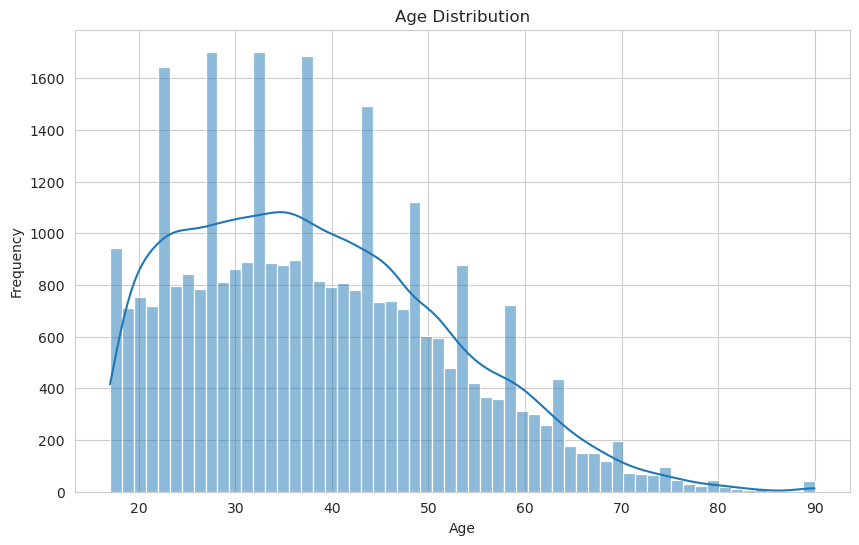

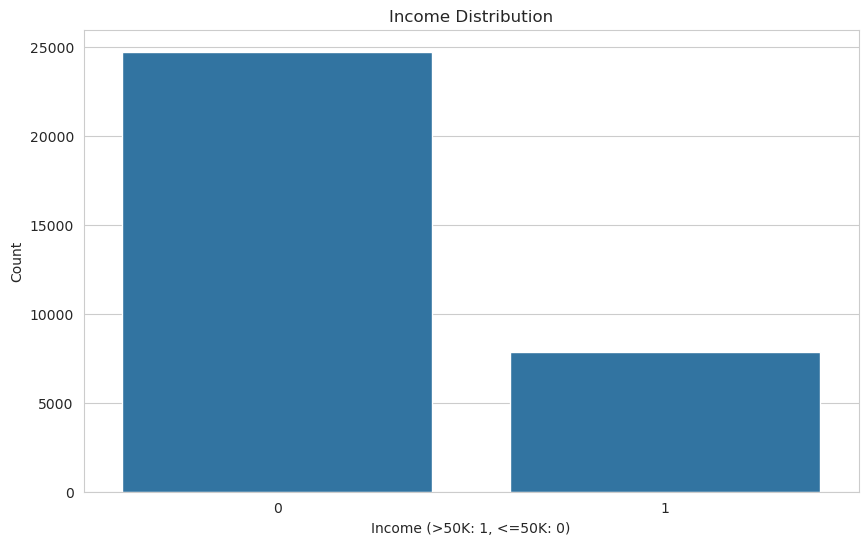

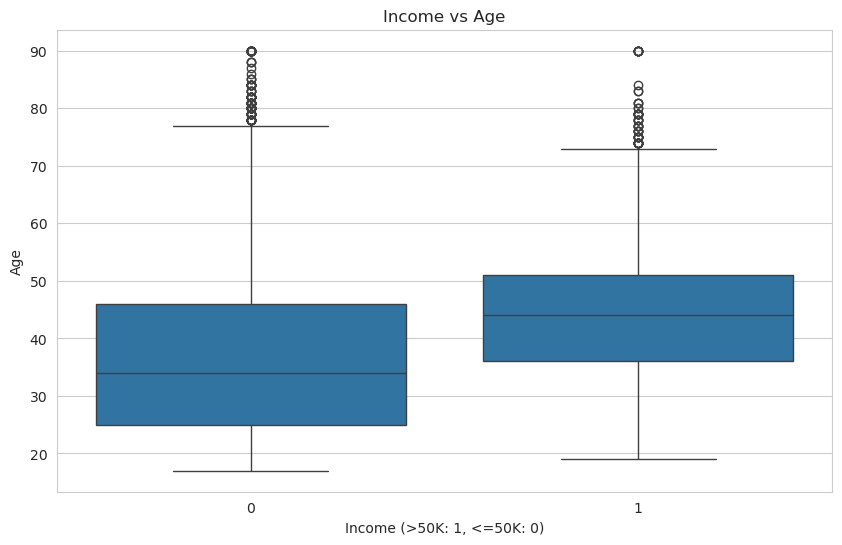

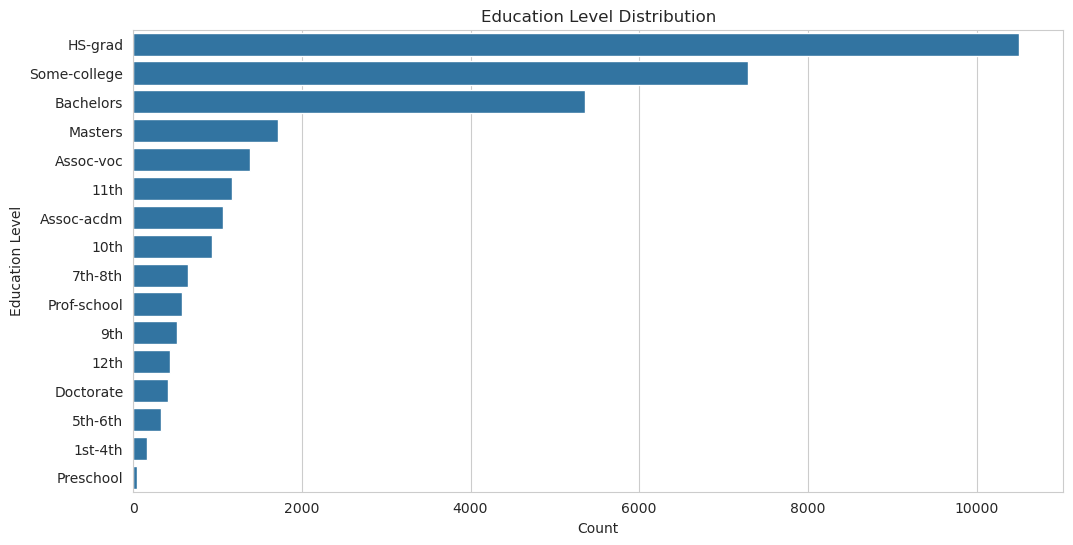

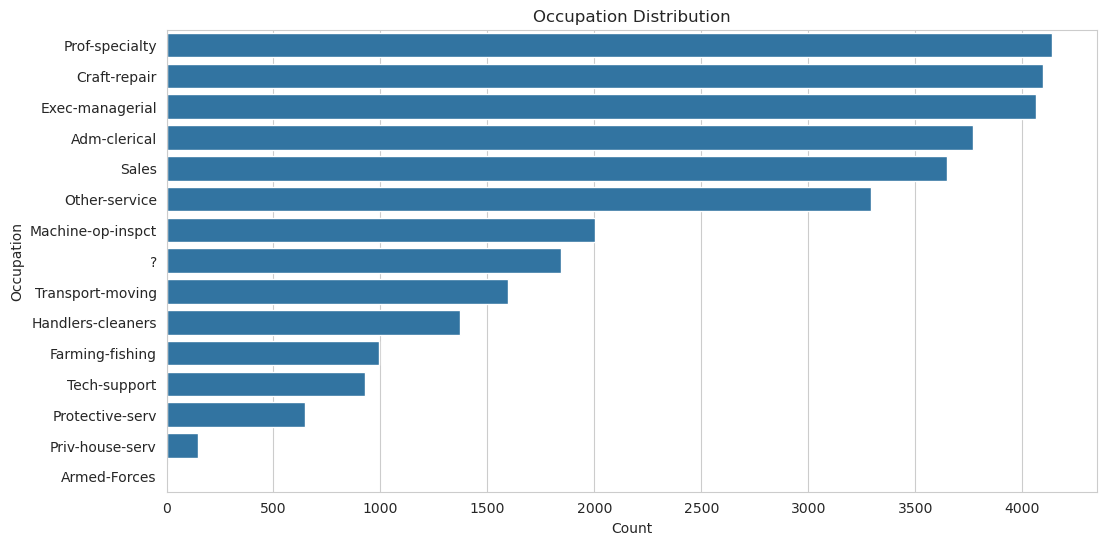

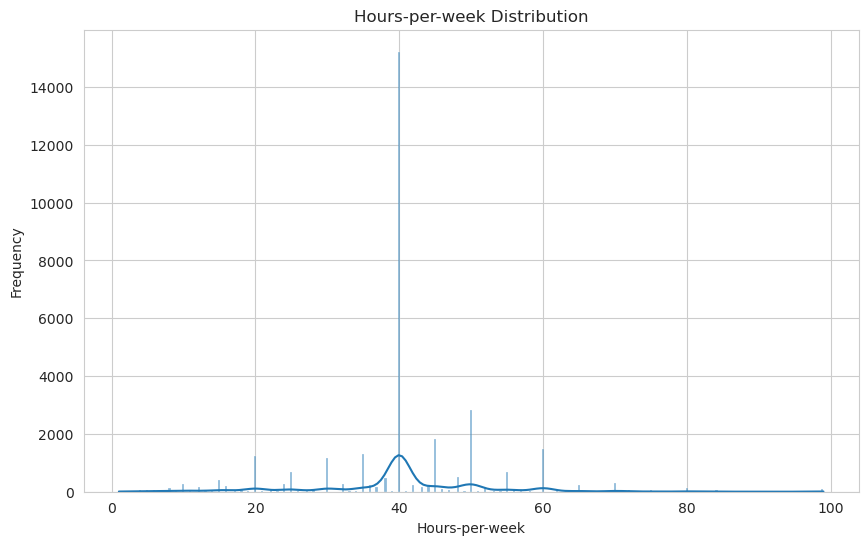

In [2]:
# import data from data/adult/adult.data
data = pd.read_csv('~/project/Jupyter/data/adult/adult.data', header=None,sep=', ',engine='python')
# name the features
data.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
print(data.head())
# 数据概览
print(data.info())

# 数据描述
print(data.describe())

# 处理缺失值（如果有）
data = data.replace(' ?', pd.NA)
data = data.dropna()

# 数据类型转换
data['income'] = data['income'].apply(lambda x: 1 if x == '>50K' else 0)

# 对字符串变量进行独热编码
# categorical_columns = data.select_dtypes(include=['object']).columns
# data_encoded = pd.get_dummies(data, columns=categorical_columns)
categorical_features = [
    'workclass', 'education', 'marital-status', 'occupation',
    'relationship', 'race', 'sex', 'native-country'
]
numerical_features = [
    'age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week'
]

# 处理离散变量：独热编码
one_hot_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
categorical_encoded = one_hot_encoder.fit_transform(data[categorical_features])
categorical_encoded_df = pd.DataFrame(categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# 处理数值变量：标准化
# scaler = StandardScaler()
# numerical_scaled = scaler.fit_transform(data[numerical_features])
# numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_features)

# 合并处理后的数据
data_encoded = pd.concat([categorical_encoded_df, data[numerical_features]], axis=1)

# 添加目标变量
data_encoded['income'] = data['income']

# 可视化：年龄分布
plt.figure(figsize=(10, 6))
sns.histplot(data['age'], kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

# 可视化：收入分布
plt.figure(figsize=(10, 6))
sns.countplot(x='income', data=data)
plt.title('Income Distribution')
plt.xlabel('Income (>50K: 1, <=50K: 0)')
plt.ylabel('Count')
plt.show()

# 可视化：收入与年龄的关系
plt.figure(figsize=(10, 6))
sns.boxplot(x='income', y='age', data=data)
plt.title('Income vs Age')
plt.xlabel('Income (>50K: 1, <=50K: 0)')
plt.ylabel('Age')
plt.show()

# 可视化：教育水平分布
plt.figure(figsize=(12, 6))
sns.countplot(y='education', data=data, order=data['education'].value_counts().index)
plt.title('Education Level Distribution')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

# 可视化：职业分布
plt.figure(figsize=(12, 6))
sns.countplot(y='occupation', data=data, order=data['occupation'].value_counts().index)
plt.title('Occupation Distribution')
plt.xlabel('Count')
plt.ylabel('Occupation')
plt.show()

# 可视化：工作时长分布
plt.figure(figsize=(10, 6))
sns.histplot(data['hours-per-week'], kde=True)
plt.title('Hours-per-week Distribution')
plt.xlabel('Hours-per-week')
plt.ylabel('Frequency')
plt.show()

# 可视化：特征相关性热力图(类别过多）
plt.figure(figsize=(120, 100))
correlation_matrix = data_encoded.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

# print(data.head())

**数据平滑**

数据平滑使用Daily Climate time series data数据集。

Daily Climate time series data数据集是在德里采集的温度，风速，大气压和湿度数据.

在这里使用Savitzky-Golay滤波器作为数据平滑方法，其主要特点是在平滑数据的同时能够保留信号的形状和宽度，从而达到较小的信息损失。

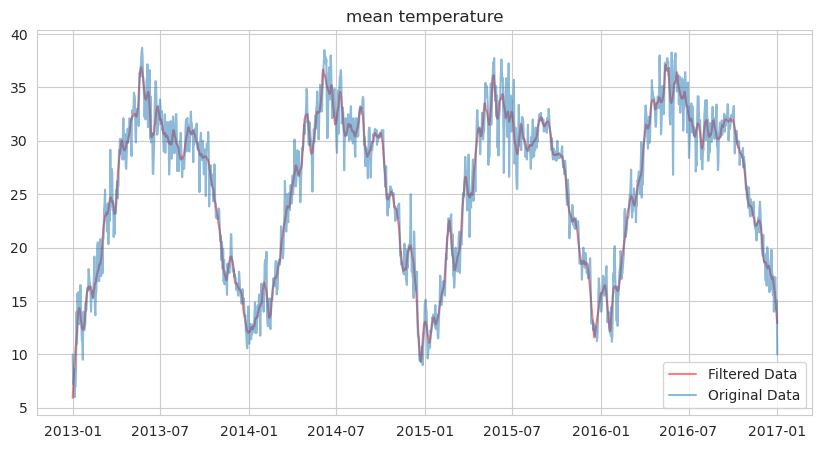

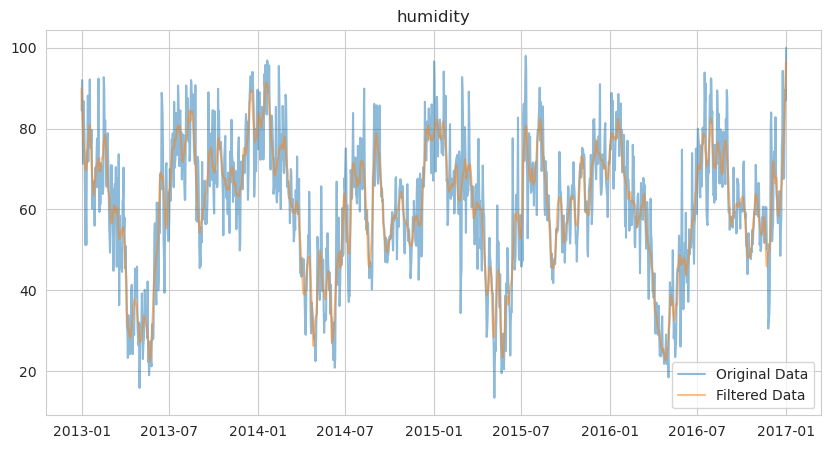

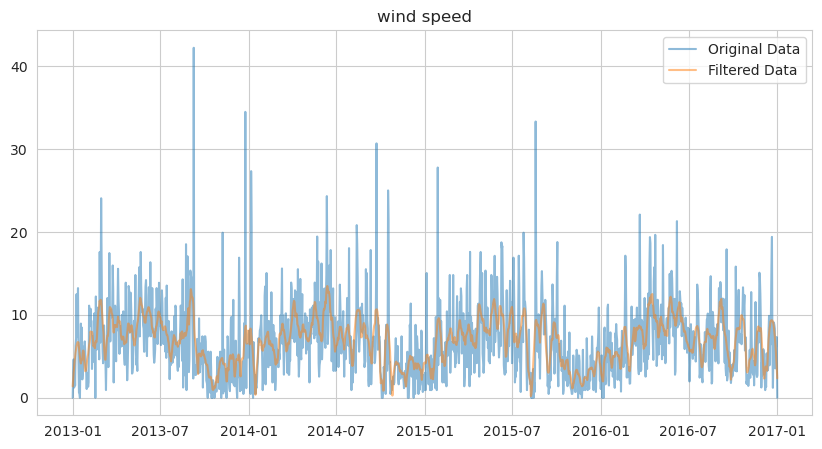

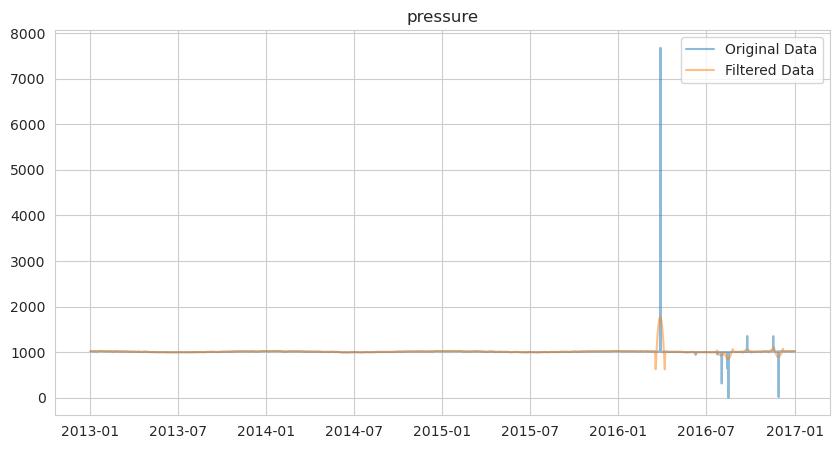

In [18]:
timeseries=pd.read_csv('~/project/Jupyter/data/climate/DailyDelhiClimateTrain.csv')
timeseries.head()
#plot
timeseries['date'] = pd.to_datetime(timeseries['date'])
timeseries.set_index('date', inplace=True)

# Savitzky-Golay滤波器
def savitzky_golay_filter(data, window_size, poly_order):
    return savgol_filter(data, window_size, poly_order)

plt.figure(figsize=(10, 5))

timeseries['smooth_temp']=savitzky_golay_filter(timeseries['meantemp'],20,2)
plt.plot(timeseries['smooth_temp'],label='Filtered Data',color='red',alpha=0.5)
plt.plot(timeseries['meantemp'],label='Original Data',alpha=0.5)
plt.legend()
plt.title('mean temperature')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timeseries['humidity'],label='Original Data',alpha=0.5)
timeseries['smooth_humidity']=savitzky_golay_filter(timeseries['humidity'],20,2)
plt.plot(timeseries['smooth_humidity'],label='Filtered Data',alpha=0.5)
plt.legend()
plt.title('humidity')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timeseries['wind_speed'],label='Original Data',alpha=0.5)
timeseries['smooth_windspeed']=savitzky_golay_filter(timeseries['wind_speed'],20,2)
plt.plot(timeseries['smooth_windspeed'],label='Filtered Data',alpha=0.5)
plt.legend()
plt.title('wind speed')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(timeseries['meanpressure'],label='Original Data',alpha=0.5)
timeseries['smooth_pressure']=savitzky_golay_filter(timeseries['meanpressure'],20,2)
plt.plot(timeseries['smooth_pressure'],label='Filtered Data',alpha=0.5)
plt.legend()
plt.title('pressure')
plt.show()



**决策树分类**

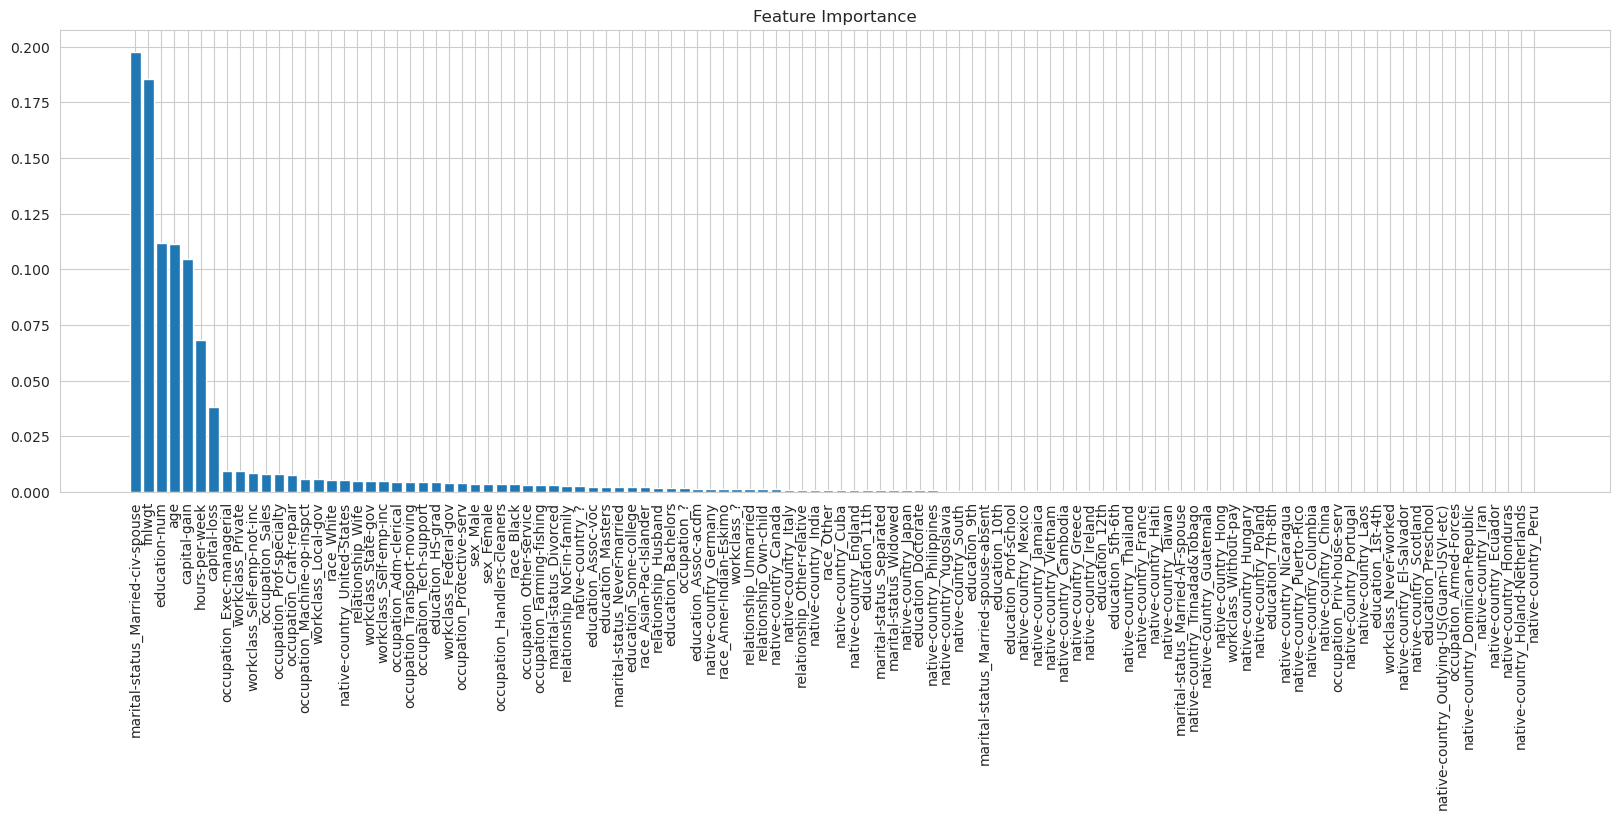

   age  workclass  fnlwgt     education  education-num      marital-status  \
0   25    Private  226802          11th              7       Never-married   
1   38    Private   89814       HS-grad              9  Married-civ-spouse   
2   28  Local-gov  336951    Assoc-acdm             12  Married-civ-spouse   
3   44    Private  160323  Some-college             10  Married-civ-spouse   
4   18          ?  103497  Some-college             10       Never-married   

          occupation relationship   race     sex  capital-gain  capital-loss  \
0  Machine-op-inspct    Own-child  Black    Male             0             0   
1    Farming-fishing      Husband  White    Male             0             0   
2    Protective-serv      Husband  White    Male             0             0   
3  Machine-op-inspct      Husband  Black    Male          7688             0   
4                  ?    Own-child  White  Female             0             0   

   hours-per-week native-country  income  
0      

In [4]:
# classification using decision tree
X = data_encoded.drop('income', axis=1)
y = data_encoded['income']
clf = DecisionTreeClassifier()
clf.fit(X, y)
importance = clf.feature_importances_
indices = np.argsort(importance)[::-1]
features = X.columns
plt.figure(figsize=(20, 6))
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title('Feature Importance')

plt.show()

#read test and test the model
test = pd.read_csv('~/project/Jupyter/data/adult/adult.test', header=None,sep=', ',engine='python',skiprows=1)
test.columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
test = test.replace(' ?', pd.NA)
test = test.dropna()
print(test.head())
test['income'] = test['income'].apply(lambda x: 1 if x == '>50K.' else 0)

test_categorical_encoded = one_hot_encoder.transform(test[categorical_features])
test_categorical_encoded_df = pd.DataFrame(test_categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

# 处理数值变量：标准化
# scaler = StandardScaler()
# numerical_scaled = scaler.fit_transform(data[numerical_features])
# numerical_scaled_df = pd.DataFrame(numerical_scaled, columns=numerical_features)

# 合并处理后的数据
test_encoded = pd.concat([test_categorical_encoded_df, test[numerical_features]], axis=1)

# 添加目标变量
test_encoded['income'] = test['income']

X_test = test_encoded.drop('income', axis=1)
# X_test.head()
y_test = test_encoded['income']
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y_test, y_pred))

**模型评估和调优**

由模型结果可知，模型最终准确率为81.10%。其中，0类（<=50k）的分类准确率，召回率和f1-score显著高于1类(>50k)。
对于模型输出结果，对此模型进行调优：标准化并采用多决策树集成学习,并采用网格搜索进行最佳参数调优

未标准化时，得到最优参数：Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'splitter': 'best'}
Best cross-validation score: 0.86

标准化后得到：
Best parameters found:  {'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 5, 'splitter': 'best'}
Best cross-validation score: 0.86

最后采用未标准化数据，进行训练，得到:




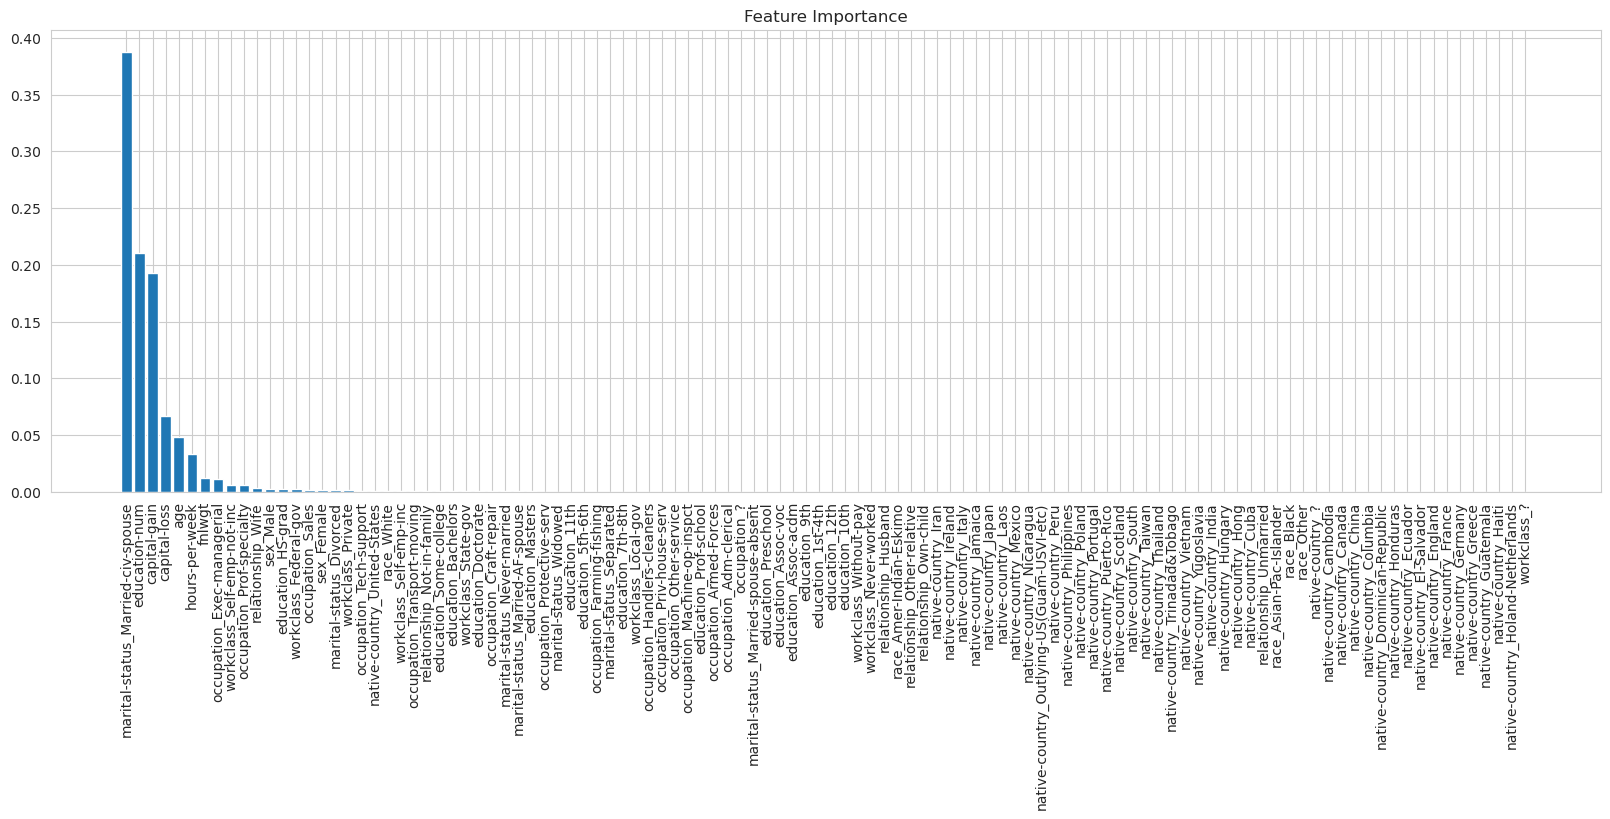

Accuracy: 0.8611264664332657
              precision    recall  f1-score   support

           0       0.88      0.94      0.91     12435
           1       0.76      0.60      0.67      3846

    accuracy                           0.86     16281
   macro avg       0.82      0.77      0.79     16281
weighted avg       0.85      0.86      0.85     16281



In [5]:
X = data_encoded.drop('income', axis=1)
y = data_encoded['income']
# clf = RandomForestClassifier(n_estimators=100)
clf = DecisionTreeClassifier(criterion='gini',max_depth=10,max_features=None,min_samples_split=2,min_samples_leaf=4,splitter='best')
clf.fit(X, y)
importance = clf.feature_importances_
indices = np.argsort(importance)[::-1]
features = X.columns
plt.figure(figsize=(20, 6))
plt.bar(range(X.shape[1]), importance[indices])
plt.xticks(range(X.shape[1]), [features[i] for i in indices], rotation=90)
plt.title('Feature Importance')

plt.show()

X_test = test_encoded.drop('income', axis=1)
X_test.head()
y_test = test_encoded['income']
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)
print(classification_report(y_test, y_pred))

## 结论

通过参数调优，得到了准确率86.08%，同时1类准确率，recall和f1-score均有显著提升的决策树分类模型。同时通过可视化能够显示对于决策树分类的重要性排序，从中得到婚姻状况、资产情况和教育情况是影响决策树分类的重要特征。同样，此决策树模型还有进一步调优优化的空间，如进行集成学习、优化预处理环节等。

# 参考数据集

Becker, B. & Kohavi, R. (1996). Adult [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C5XW20.